# Intro

Here is a Google Colab Notebook for model testing. Please input the file name you would like to test, and the predictor column. (The file is set for Listeria and Salmonella/Campylobacter)

This is the most up-to-date, tried and tested method I used to develop the baseline code for the model testing AND results.

In this notebook, the exact same models that are provided on the competition, official git repo are used. The code is adapted to perform a grid search (search through a list of hyper parameters) to find the best model results.

I designed it to save all model results into the local files because of the testing we needed to do for my personal project, however, this code can be streamlined by running a Random Search or a pre-packaged, optimized Grid Search instead of the for loops.


NOTE: Please remember to download/save the csv from the Files section on google collab if you want to keep your results.

# How to Run the Models

## STEP 1: Uploading files to run
- Select the files icon and upload the desired file (i.e. SalCampChicken_clean.csv)

## STEP 2: Altering file name, y column/predictor, and other main decisions effecting all models
- Edit the **global variables**.
- NOTE: if you search for STEP 2, the cell(s) where STEP 2 are listed are the cells where you can edit anything!

    

## Optional STEP 3: Editing or adding a hyperparameter(s)
- in each model option (function = *test_"model name"*, i.e. test_knn), edit the hyperparameters to search through
- NOTE: if you search for STEP 3, the cell(s) where STEP 3 are listed are the cells where you can edit anything!
- NOTE: if adding another hyperparameter:
  1) Add the hyperparameter as a list
  2) Add a for loop
  3) Adjust the results_column from STEP 2
  4) Adjust each *test_"Model"*'s results/output to have the hyperparameters, and put np.nan as the output


## Optional STEP 4: Adding a model
1) add the model package to the imports section
2) add a new codeing section
3) name the function *test_"model"* for consistency
4) copy and paste a similar model
5) adjust the hyperparameters, and add or subtract for loops as needed
6) edit the hyperparameter options in the results_column (from STEP\_2) and each of the returning results/outputs in each *test_"model"* function

## STEP 5: Choosing models to run
- in the *run_models_for_file* function, comment or uncomment the lines in the variable **model_fns** to decide which models to run

# STEP 6: Running all cells
- hit the Run all button as listed above



# How to Run the Results (Scroll down to "Analyze Results" section and start there)

## If already have results file and do not want to run the modeling section
- go to the files icon in google colab, and upload the results file

### STEP 1: Change global variables
- edit any of the variables, such as the "primary metric" to be on your visuals

### STEP 2: Runninng analyze
- go through and run cells as needed

In [3]:
# imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from keras.models import Sequential
from keras.layers import Dense, Input
from keras import backend as K
import re
from pathlib import Path, PurePosixPath
from dataclasses import dataclass, asdict
from concurrent.futures import ProcessPoolExecutor, as_completed
import os
import json
from sklearn.inspection import permutation_importance
import tempfile
from sklearn.model_selection import train_test_split
from tqdm import tqdm


# This is where modeling begins.

Below, feel free to change test size, column results to save, and the y-col to use.

For salmonella/campylobacter, the possible predictor column of your choosing.

The Salmonella/campylobacter column was created by an OR statement of the Salmonella OR Campylobacter status.

In [ ]:
# STEP 2: Edit any of these variables in these sections

# saving global variables
TEST_SIZE = .22  # for validation (Pick a number between .1-.99 to reflect percentage)
RANDOM_STATE = 42  # for repeatability
# developing results table to plot

DATA_PATH = None
# !!!!!! IF YOU ARE RUNNING IN VISUAL STUDIO, UNCOMMENT THE CODE BELOW
# ROOT = Path.cwd()
# if ROOT.name == "preparation":
#     ROOT = ROOT.parent
# DATA = ROOT / "data"


# getting in file path
try:
    file_info = Path(DATA_PATH / "ListeriaSoil_clean_log.csv") # Path("INPUT FILE NAME HERE") i.e. Path("SalCampChicken_clean.csv")
except:
    try:
        file_info = Path("ListeriaSoil_clean_log.csv")
    except Exception as e:
        raise e
# TODO OPTIONS:
# OPTIONS FOR LISTERIA:
    # Number of Listia Isolates: origianl predictor present in dataset
    # binary_listeria_presense:
# y_col = "Salmon_or_camp_test"
Y_COL = "binary_listeria_presense"

# If want all strings/catagorical data to be encoded in 1-hot vectors 
# (aka want to transform arbitrary strings into integer values)
ENCODE_STR = False


# Preparing the data

In [ ]:
# Data Preperation
def data_prep(file_info):
    """
    ----- inputs -----
    file_info: Path object
        file wanting to process
    ----- outputs ----
    df: pandas df
        processed anonymzied data (string columns representing intervals split into min and max, then put as minimum and maximum values for those columns)
    """

    df = pd.read_csv(Path(file_info.name))

    # if salcamp column, then adding it to the dataset
    if Y_COL == "Salmon_or_camp_test":
        df["Salmon_or_camp_test"] = (df["CampylobacterAnalysis30ml"] == "Positive") | (df["SalmonellaSPAnalysis"] == "Positive")
    if Y_COL == "binary_listeria_presense":
        df['binary_listeria_presense'] = [row_val if row_val == 0 else 1 for row_val in df['Number of Listeria isolates obtained']]

    # switching missing values and weird failures in writing to np.inf bc pandas didnt handle properly
    df = df.replace("#NAME?", -np.inf)
    df = df.fillna(-np.inf)

    # replacing inf with max number that is not max number + 100 in dict (FOR NOT JUST 99999999)
    df = df.replace(np.inf, 99999)
    # replacing -inf with min number (not -inf) - 100 in dict (FOR NOT JUST -99999999)
    df = df.replace(-np.inf, -99999)

    df = df.dropna(axis=1, how="all")

    if ENCODE_STR:
        df = pd.get_dummies(df)
    return df

# Splitting into Train and Test sets

In [ ]:

def get_train_test(
    df, y_col=Y_COL, scaling_used=True
):
    """
    ----- inputs -----
    df: pandas dict
        processed data (all numerics)
    y_col: str
        string of y labels
    test_size: int
        % want test set to be of full data
    scaling_used: boolean
        whether to test scaled data and original data (True) or only original data (False)
    ----- outputs ----
    data_testing: dict[str=scalingType][str=y/X train/test label][pd.DataFrame]
        dictionary contianing
            * string of scaling type (standard scalar, orig)
                * string of what dataset grabbing (X_train, X_test, y_train, y_test)
                    * corresponding data in a pandas dataframe
        "
    """

    # indexes for test set
    X = df.drop(columns=Y_COL)
    y = df[Y_COL]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    # data columns
    data_columns = X.columns

    if scaling_used:  # if want to run on scaled and original data
        # testing all with and without scaled data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train.values)
        X_test_scaled = scaler.transform(X_test.values)

        data_testing = {
            "columns": data_columns,
            "standard_scalar": {
                "X_train": X_train_scaled,
                "X_test": X_test_scaled,
                "y_train": y_train,  # using unscaled y
                "y_test": y_test,  # using unscaled y
            },
            "orig": {
                "X_train": X_train,
                "X_test": X_test,
                "y_train": y_train,
                "y_test": y_test,
            },
        }

        return data_testing

    else:  # if only want to run on original data
        data_testing = {
            "columns": data_columns,
            "orig": {
                "X_train": X_train,
                "X_test": X_test,
                "y_train": y_train,
                "y_test": y_test,
            }
        }
        return data_testing


# Modeling Section

In [ ]:
def test_svm(data_testing, file_info):
    """
    ----- inputs -----
    data_testing: dict[str=scalingType][str=y/X train/test label][pd.DataFrame]
        dictionary contianing
            * string of scaling type (standard scalar, orig)
                * string of what dataset grabbing (X_train, X_test, y_train, y_test)
                    * corresponding data in a pandas dataframe
    ----- outputs ----

    """

    # results table
    svm_results = []

    # STEP 3: can edit HYPERPARAMETERs: for svm variables
    c_vals = [0.01, 0.1, 1, 4, 8]
    svm_kernels = ['linear', 'rbf', 'sigmoid']

    # grid searching model results for svm on all types of data with all types of inputs
    for scalar_type in tqdm(data_testing.keys(), desc="svm scaled vs original"):
        if scalar_type == 'columns':
            continue
        X_test = data_testing[scalar_type]["X_test"]
        X_train = data_testing[scalar_type]["X_train"]
        y_train = data_testing[scalar_type]["y_train"]
        y_test = data_testing[scalar_type]["y_test"]
        feature_names = data_testing["columns"].tolist()

        # going through possible svm combos
        for c_val in c_vals:
            for svm_kernel in svm_kernels:
                # modeling portion
                model = SVC(C=c_val, kernel=svm_kernel)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                # validation
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, zero_division=0)
                recall = recall_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred, zero_division=0)
                conf_matrix = confusion_matrix(y_test, y_pred)

                # getting feature importance
                coefficients = np.nan
                feature_imp = np.nan
                feature_imp_json = np.nan
                if svm_kernel == 'linear':
                    coefficients = model.coef_.ravel()
                    feature_imp = dict(zip(feature_names, coefficients))
                    feature_imp_json = json.dumps({k: float(v) for k, v in feature_imp.items()})

                # getting permutation importance
                perm = permutation_importance(
                    model, X_test, y_test,
                    n_repeats=10,
                    random_state=RANDOM_STATE,
                    scoring="f1"  # or "accuracy"
                )

                perm_imp = dict(zip(feature_names, perm.importances_mean))
                perm_imp_json = json.dumps({k: float(v) for k, v in perm_imp.items()})

                # STEP 3, add any hyperparameters to each of these results/outputs: saving results to dict
                svm_results.append(
                    {
                        "file name": file_info.name,
                        "accuracy": accuracy,
                        "precision": precision,
                        "recall": recall,
                        "f1": f1,
                        "confusion matrix": conf_matrix,
                        "test size": TEST_SIZE,
                        "random state": RANDOM_STATE,
                        "scalar_status": scalar_type,
                        "y variable used": Y_COL,
                        "model used": "svm",
                        "logistic_reg_c": np.nan,
                        "lr_ratios": np.nan,
                        "nn_layers": np.nan,
                        "nn_neurons": np.nan,
                        "nn_batch_size": np.nan,
                        "nn_epochs": np.nan,
                        "dt_max_depth": np.nan,
                        "dt_min_samples_split": np.nan,
                        "svm_c_val": c_val,
                        "svm_kernel": svm_kernel,
                        "knn_weights": np.nan,
                        "gbm_learning_rate": np.nan,
                        "gbm_n_estimator": np.nan,
                        "coefficient_importance": feature_imp_json,
                        "permutation_importance": perm_imp_json,
                    }
                )

    return svm_results


In [ ]:
def test_logistic_reg(data_testing, file_info):
    """
    ----- inputs -----
    data_testing: dict[str=scalingType][str=y/X train/test label][pd.DataFrame]
        dictionary contianing
            * string of scaling type (standard scalar, orig)
                * string of what dataset grabbing (X_train, X_test, y_train, y_test)
                    * corresponding data in a pandas dataframe
    ----- outputs ----

    """

    log_reg_results = []

    # STEP 3: can edit HYPERPARAMETERS: for logistic regression variables
    # c_vals = [0.0001, 0.001, 0.01, 0.1, 1, 2, 4, 8, 32, 56, 100]
    c_vals = [0.01, 0.1, 1, 4, 8]
    # lr_ratios = [0, 0.5, 1] # 0 = l2 penalty, 1 = l1 penalty, 0.5 = elasticnet penalty (both L1 and L2)
    lr_ratios = [
        0,
        1,
    ]  # 0 = l2 penalty, 1 = l1 penalty, 0.5 = elasticnet penalty (both L1 and L2)

    # grid searching model results for log reg on all types of data with all types of inputs
    for scalar_type in tqdm(data_testing.keys(), desc="logistic regression scaled vs original"):

        # breakpoint()

        if scalar_type == 'columns':
            continue
        # print("data testing is :", type(data_testing), " \n", data_testing)
        X_test = data_testing[scalar_type]["X_test"]
        X_train = data_testing[scalar_type]["X_train"]
        y_train = data_testing[scalar_type]["y_train"]
        y_test = data_testing[scalar_type]["y_test"]
        feature_names = data_testing["columns"].tolist()

        # breakpoint()

        # going through possible log reg combos
        for c_val in c_vals:
            for lr_rat in lr_ratios:
                # modeling portion
                model = LogisticRegression(C=c_val, l1_ratio=lr_rat)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                # validation
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, zero_division=0)
                recall = recall_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred, zero_division=0)
                conf_matrix = confusion_matrix(y_test, y_pred)

                # getting feature importance
                coefficients = model.coef_.ravel()
                feature_imp = dict(zip(feature_names, coefficients))
                feature_imp_json = json.dumps({k: float(v) for k, v in feature_imp.items()})

                # getting permutation importance
                perm = permutation_importance(
                    model, X_test, y_test,
                    n_repeats=10,
                    random_state=RANDOM_STATE,
                    scoring="f1"  # or "accuracy"
                )

                perm_imp = dict(zip(feature_names, perm.importances_mean))
                perm_imp_json = json.dumps({k: float(v) for k, v in perm_imp.items()})

                # STEP 3, add any hyperparameters to each of these results/outputs: saving results to dictfile_path: str
                log_reg_results.append(
                    {
                        "file name": file_info.name,
                        "accuracy": accuracy,
                        "precision": precision,
                        "recall": recall,
                        "f1": f1,
                        "confusion matrix": conf_matrix,
                        "test size": TEST_SIZE,
                        "random state": RANDOM_STATE,
                        "scalar_status": scalar_type,
                        "y variable used": Y_COL,
                        "model used": "logistic regression",
                        "logistic_reg_c": c_val,
                        "lr_ratios": lr_rat,
                        "nn_layers": np.nan,
                        "nn_neurons": np.nan,
                        "nn_batch_size": np.nan,
                        "nn_epochs": np.nan,
                        "dt_max_depth": np.nan,
                        "dt_min_samples_split": np.nan,
                        "svm_c_val": np.nan,
                        "svm_kernel": np.nan,
                        "knn_n_neighbor": np.nan,
                        "knn_weights": np.nan,
                        "gbm_learning_rate": np.nan,
                        "gbm_n_estimator": np.nan,
                        "coefficient_importance": feature_imp_json,
                        "permutation_importance": perm_imp_json,
                    }
                )

    return log_reg_results


In [ ]:
def test_knn(data_testing, file_info):
    """
    ----- inputs -----
    data_testing: dict[str=scalingType][str=y/X train/test label][pd.DataFrame]
        dictionary contianing
            * string of scaling type (standard scalar, orig)
                * string of what dataset grabbing (X_train, X_test, y_train, y_test)
                    * corresponding data in a pandas dataframe
    ----- outputs ----

    """

    # results table
    knn_results = []

    # STEP 3: can edit HYPERPARAMETERS: for knn variables
    knn_n_neighbors = [2, 5, 10, 15, 20]
    weights = ['uniform', 'distance']

    # grid searching model results for knn on all types of data with all types of inputs
    for scalar_type in tqdm(data_testing.keys(), desc="knn scaled vs original"):
        if scalar_type == 'columns':
            continue
        X_test = data_testing[scalar_type]["X_test"]
        X_train = data_testing[scalar_type]["X_train"]
        y_train = data_testing[scalar_type]["y_train"]
        y_test = data_testing[scalar_type]["y_test"]
        feature_names = data_testing["columns"].tolist()

        # going through possible KNN combos
        for knn_n_neighbor in knn_n_neighbors:
            for weight in weights:
                # modeling portion
                model = KNeighborsClassifier(
                    n_neighbors=knn_n_neighbor, weights=weight
                )
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                # validation
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, zero_division=0)
                recall = recall_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred, zero_division=0)
                conf_matrix = confusion_matrix(y_test, y_pred)

                # getting permutation importance
                perm = permutation_importance(
                    model, X_test, y_test,
                    n_repeats=3, # reduced number to speed things up significantly
                    random_state=RANDOM_STATE,
                    scoring="f1"  # or "accuracy"
                )

                perm_imp = dict(zip(feature_names, perm.importances_mean))
                perm_imp_json = json.dumps({k: float(v) for k, v in perm_imp.items()})

                # STEP 3, add any hyperparameters to each of these results/outputs: saving results to dict
                knn_results.append(
                    {
                        "file name": file_info.name,
                        "accuracy": accuracy,
                        "precision": precision,
                        "recall": recall,
                        "f1": f1,
                        "confusion matrix": conf_matrix,
                        "test size": TEST_SIZE,
                        "random state": RANDOM_STATE,
                        "scalar_status": scalar_type,
                        "y variable used": Y_COL,
                        "model used": "knn",
                        "logistic_reg_c": np.nan,
                        "lr_ratios": np.nan,
                        "nn_layers": np.nan,
                        "nn_neurons": np.nan,
                        "nn_batch_size": np.nan,
                        "nn_epochs": np.nan,
                        "dt_max_depth": np.nan,
                        "dt_min_samples_split": np.nan,
                        "svm_c_val": np.nan,
                        "svm_kernel": np.nan,
                        "knn_n_neighbor": knn_n_neighbor,
                        "knn_weights": weight,
                        "gbm_learning_rate": np.nan,
                        "gbm_n_estimator": np.nan,
                        "coefficient_importance": np.nan,
                        "permutation_importance": perm_imp_json,
                    }
                )

    return knn_results


In [ ]:
def test_neural_net(data_testing, file_info):
    """
    ----- inputs -----
    data_testing: dict[str=scalingType][str=y/X train/test label][pd.DataFrame]
        dictionary contianing
            * string of scaling type (standard scalar, orig)
                * string of what dataset grabbing (X_train, X_test, y_train, y_test)
                    * corresponding data in a pandas dataframe
    ----- outputs ----

    """
    # results table
    neur_net_results = []

    #  STEP 3: can edit HYPERPARAMETERS: for neural net
    nn_layers_list = [1, 2, 3, 4]
    nn_neurons_list = [16, 32, 64, 128, 256]
    nn_batch_size_list = [32, 64, 128, 256]
    nn_epochs_list = [5, 10, 20]

    # grid searching model results for neural net on all types of data with all types of inputs
    for scalar_type in tqdm(data_testing.keys(), desc="neural net scaled vs original"):
        if scalar_type == 'columns':
            continue
        X_test = data_testing[scalar_type]["X_test"]
        X_train = data_testing[scalar_type]["X_train"]
        y_train = data_testing[scalar_type]["y_train"]
        y_test = data_testing[scalar_type]["y_test"]

        # going through possible neural net combos
        for nn_layers in nn_layers_list:
            for nn_neurons in nn_neurons_list:
                for nn_batch_size in nn_batch_size_list:
                    for nn_epochs in nn_epochs_list:
                        # modeling portion
                        model = Sequential()
                        model.add(Input(shape=(X_train.shape[1],)))
                        for _ in range(nn_layers):
                            model.add(Dense(nn_neurons, activation="relu"))
                        model.add(Dense(1, activation="sigmoid"))
                        model.compile(
                            optimizer="adam",
                            loss="binary_crossentropy",
                            metrics=["accuracy"],
                        )
                        model.fit(
                            X_train,
                            y_train,
                            epochs=nn_epochs,
                            batch_size=nn_batch_size,
                            verbose=0,
                        )
                        y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

                        # validation
                        accuracy = accuracy_score(y_test, y_pred)
                        precision = precision_score(y_test, y_pred, zero_division=0)
                        recall = recall_score(y_test, y_pred, zero_division=0)
                        f1 = f1_score(y_test, y_pred, zero_division=0)
                        conf_matrix = confusion_matrix(y_test, y_pred)

                        # STEP 3, add any hyperparameters to each of these results/outputs: saving results to dict
                        neur_net_results.append(
                            {
                                "file name": file_info.name,
                                "accuracy": accuracy,
                                "precision": precision,
                                "recall": recall,
                                "f1": f1,
                                "confusion matrix": conf_matrix,
                                "test size": TEST_SIZE,
                                "random state": RANDOM_STATE,
                                "scalar_status": scalar_type,
                                "y variable used": Y_COL,
                                "model used": "neural net",
                                "logistic_reg_c": np.nan,
                                "lr_ratios": np.nan,
                                "nn_layers": nn_layers,
                                "nn_neurons": nn_neurons,
                                "nn_batch_size": nn_batch_size,
                                "nn_epochs": nn_epochs,
                                "dt_max_depth": np.nan,
                                "dt_min_samples_split": np.nan,
                                "svm_c_val": np.nan,
                                "svm_kernel": np.nan,
                                "knn_n_neighbor": np.nan,
                                "knn_weights": np.nan,
                                "gbm_learning_rate": np.nan,
                                "gbm_n_estimator": np.nan,
                                "coefficient_importance": np.nan,
                                "permutation_importance": np.nan,
                            }
                        )

    return neur_net_results


In [ ]:
def test_gbm(data_testing, file_info):
    """
    ----- inputs -----
    data_testing: dict[str=scalingType][str=y/X train/test label][pd.DataFrame]
        dictionary contianing
            * string of scaling type (standard scalar, orig)
                * string of what dataset grabbing (X_train, X_test, y_train, y_test)
                    * corresponding data in a pandas dataframe
    ----- outputs ----

    """
    # results table
    gbm_results = []

    #  STEP 3: can edit HYPERPARAMETERS: for gbm variables
    gbm_learning_rates = [0.01, 0.05, 0.1, 0.2]
    gbm_n_estimators = [100, 200, 400, 800]

    # grid searching model results for gbm on all types of data with all types of inputs
    for scalar_type in tqdm(data_testing.keys(), desc="gbm scaled vs original"):
        if scalar_type == 'columns':
            continue
        X_test = data_testing[scalar_type]["X_test"]
        X_train = data_testing[scalar_type]["X_train"]
        y_train = data_testing[scalar_type]["y_train"]
        y_test = data_testing[scalar_type]["y_test"]
        feature_names = data_testing["columns"].tolist()

        # going through possible gbm combos
        for gbm_learning_rate in gbm_learning_rates:
            for gbm_n_estimator in gbm_n_estimators:
                # modeling portion
                model = GradientBoostingClassifier(
                    learning_rate=gbm_learning_rate, n_estimators=gbm_n_estimator
                )
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                # validation
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, zero_division=0)
                recall = recall_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred, zero_division=0)
                conf_matrix = confusion_matrix(y_test, y_pred)

                # getting feature importance
                gbm_imp = model.feature_importances_
                feature_imp = dict(zip(feature_names, gbm_imp))
                feature_imp_json = json.dumps({k: float(v) for k, v in feature_imp.items()})

                # getting permutation importance
                perm = permutation_importance(
                    model, X_test, y_test,
                    n_repeats=10,
                    random_state=RANDOM_STATE,
                    scoring="f1"  # or "accuracy"
                )

                perm_imp = dict(zip(feature_names, perm.importances_mean))
                perm_imp_json = json.dumps({k: float(v) for k, v in perm_imp.items()})

                # STEP 3, add any hyperparameters to each of these results/outputs: saving results to dict
                gbm_results.append(
                    {
                        "file name": file_info.name,
                        "accuracy": accuracy,
                        "precision": precision,
                        "recall": recall,
                        "f1": f1,
                        "confusion matrix": conf_matrix,
                        "test size": TEST_SIZE,
                        "random state": RANDOM_STATE,
                        "scalar_status": scalar_type,
                        "y variable used": Y_COL,
                        "model used": "gbm",
                        "logistic_reg_c": np.nan,
                        "lr_ratios": np.nan,
                        "nn_layers": np.nan,
                        "nn_neurons": np.nan,
                        "nn_batch_size": np.nan,
                        "nn_epochs": np.nan,
                        "dt_max_depth": np.nan,
                        "dt_min_samples_split": np.nan,
                        "svm_c_val": np.nan,
                        "svm_kernel": np.nan,
                        "knn_n_neighbor": np.nan,
                        "knn_weights": np.nan,
                        "gbm_learning_rate": gbm_learning_rate,
                        "gbm_n_estimator": gbm_n_estimator,
                        "coefficient_importance": feature_imp_json,
                        "permutation_importance": perm_imp_json,
                    }
                )
    return gbm_results

In [ ]:
def test_decision_tree(data_testing, file_info):
    """
    ----- inputs -----
    data_testing: dict[str=scalingType][str=y/X train/test label][pd.DataFrame]
        dictionary contianing
            * string of scaling type (standard scalar, orig)
                * string of what dataset grabbing (X_train, X_test, y_train, y_test)
                    * corresponding data in a pandas dataframe
    ----- outputs ----

    """
    # results table
    dec_tree_results = []

    #  STEP 3: can edit HYPERPARAMETERS: for decision tree variables
    dt_max_depths = [50, 100, 200, 400, None]
    dt_min_samples_splits = [2, 10, 20, 50]

    # grid searching model results for decision tree on all types of data with all types of inputs
    for scalar_type in tqdm(data_testing.keys(), desc="decision tree scaled vs original"):
        if scalar_type == 'columns':
            continue
        X_test = data_testing[scalar_type]["X_test"]
        X_train = data_testing[scalar_type]["X_train"]
        y_train = data_testing[scalar_type]["y_train"]
        y_test = data_testing[scalar_type]["y_test"]
        feature_names = data_testing["columns"].tolist()

        # going through possible decision tree combos
        for dt_min_samples_split in dt_min_samples_splits:
            for dt_max_depth in dt_max_depths:
                # modeling portion
                model = DecisionTreeClassifier(
                    max_depth=dt_max_depth, min_samples_split=dt_min_samples_split
                )
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                # validation
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, zero_division=0)
                recall = recall_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred, zero_division=0)
                conf_matrix = confusion_matrix(y_test, y_pred)

                # getting feature importance
                tree_imp = model.feature_importances_
                feature_imp = dict(zip(feature_names, tree_imp))
                feature_imp_json = json.dumps({k: float(v) for k, v in feature_imp.items()})

                # getting permutation importance
                perm = permutation_importance(
                    model, X_test, y_test,
                    n_repeats=10,
                    random_state=RANDOM_STATE,
                    scoring="f1"  # or "accuracy"
                )

                perm_imp = dict(zip(feature_names, perm.importances_mean))
                perm_imp_json = json.dumps({k: float(v) for k, v in perm_imp.items()})

                # STEP 3, add any hyperparameters to each of these results/outputs
                dec_tree_results.append(
                    {
                        "file name": file_info.name,
                        "accuracy": accuracy,
                        "precision": precision,
                        "recall": recall,
                        "f1": f1,
                        "confusion matrix": conf_matrix,
                        "test size": TEST_SIZE,
                        "random state": RANDOM_STATE,
                        "scalar_status": scalar_type,
                        "y variable used": Y_COL,
                        "model used": "decision_tree",
                        "logistic_reg_c": np.nan,
                        "lr_ratios": np.nan,
                        "nn_layers": np.nan,
                        "nn_neurons": np.nan,
                        "nn_batch_size": np.nan,
                        "nn_epochs": np.nan,
                        "dt_max_depth": dt_max_depth,
                        "dt_min_samples_split": dt_min_samples_split,
                        "svm_c_val": np.nan,
                        "svm_kernel": np.nan,
                        "knn_n_neighbor": np.nan,
                        "knn_weights": np.nan,
                        "gbm_learning_rate": np.nan,
                        "gbm_n_estimator": np.nan,
                        "coefficient_importance": feature_imp_json,
                        "permutation_importance": perm_imp_json,
                    }
                )

    return dec_tree_results


# Prepping the models to Run

In [ ]:
def run_models_for_file(file_info) -> list:
    """
    Goal: return model results for file

    Paramaters:
        file: str
            the name of the file want to model
        file_info: Path object
            parsed information about the file

    Outputs:
        all_rows: list
            list of the dictionary model results
    """

    df = data_prep(file_info)
    if df.empty:
        return []

    data_testing = get_train_test(df, y_col=Y_COL, scaling_used=True)

    # STEP 5: Choosing which model results to run (comment or uncomment models as needed)
    # STEP 4: Add model name here if needed
    model_fns = [
        test_logistic_reg,
        # test_neural_net,
        # test_knn,
        test_decision_tree,
        # test_svm,
        # test_gbm,
    ]

    # running each model in the model funcs list to return the results
    all_rows = []
    for fn in model_fns:
        rows = fn(data_testing, file_info) # running each function
        if rows:
            all_rows.extend(rows)

    return all_rows


# Running all Models

In [ ]:
# running each model to get results
rows_results = run_models_for_file(file_info) # calling function to run models
dataframe_rows_results = pd.DataFrame(rows_results) # converting into a dataframe, so that we can save it
dataframe_rows_results.to_csv(f'results_for_{file_info.name}') # saving it into the files section as a CSV
print("\n\nCOMPLETED: k\n\n")

C:\Users\ameli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\ameli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\ameli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\ameli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packag



COMPLETED: k




# Analyzing Results

In [ ]:
# imports
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import re
import json
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay


In [ ]:
# STEP 1 for analyze results global variables!
results_df = pd.read_csv(f"results_for_{file_info}.csv")

hyperparam_cols = [
    "logistic_reg_c", "lr_ratios",
    "nn_layers", "nn_neurons", "nn_batch_size", "nn_epochs",
    "dt_max_depth", "dt_min_samples_split",
    "svm_c_val", "svm_kernel",
    "knn_n_neighbor", "knn_metric",
    "gbm_learning_rate", "gbm_n_estimator",
]

# Base grouping keys
base_cols = ["model used", "scalar_status"]
# DO NOT CHANGE THE LINE BELOW: This defines a "hyperparam combo"
combo_cols = base_cols + hyperparam_cols

# whatever you want your graphs to be looking at
primary_metric = 'accuracy'


## Helper functions for analyzing results

In [41]:
def parse_confusion_matrix(cm_str):
    """
    Parses strings like:
      '[[0 7]\n [0 8]]'
      '[[7 0]\n [8 0]]'
    Returns tn, fp, fn, tp as ints, or NaNs if missing.
    """
    if pd.isna(cm_str):
        return np.nan, np.nan, np.nan, np.nan

    s = str(cm_str).strip()

    # extract 4 integers in row-major order
    nums = re.findall(r"-?\d+", s)
    if len(nums) < 4:
        return np.nan, np.nan, np.nan, np.nan

    tn, fp, fn, tp = map(int, nums[:4])
    return tn, fp, fn, tp

def safe_div(a, b):
    return np.where(b == 0, np.nan, a / b)

In [42]:
def add_derived_columns(df):
    # Parse confusion matrix
    tn_fp_fn_tp = df["confusion matrix"].apply(parse_confusion_matrix)
    df[["tn", "fp", "fn", "tp"]] = pd.DataFrame(tn_fp_fn_tp.tolist(), index=df.index)

    # test n (prefer your stored test size; otherwise derive from cm)
    df["n_test_cm"] = df[["tn", "fp", "fn", "tp"]].sum(axis=1)
    df["n_test"] = df["test size"].where(~df["test size"].isna(), df["n_test_cm"])

    # getting rate metrics!
    df["tpr_recall"] = safe_div(df["tp"], (df["tp"] + df["fn"]))         # same as recall
    df["tnr_specificity"] = safe_div(df["tn"], (df["tn"] + df["fp"]))
    df["fpr"] = safe_div(df["fp"], (df["fp"] + df["tn"]))
    df["pred_pos_rate"] = safe_div((df["tp"] + df["fp"]), df["n_test"])
    df["prevalence"] = safe_div((df["tp"] + df["fn"]), df["n_test"])

    df["balanced_accuracy"] = 0.5 * (df["tpr_recall"] + df["tnr_specificity"])

    # Degenerate predictor flags
    df["degenerate_all_pos"] = (df["tn"] == 0) & (df["fn"] == 0) & df["n_test"].notna()
    df["degenerate_all_neg"] = (df["tp"] == 0) & (df["fp"] == 0) & df["n_test"].notna()

    # clean model name
    df["model used"] = df["model used"].astype(str).str.strip().str.lower()
    return df

# Immediately adding the parsed cols
results_df = add_derived_columns(results_df)

## Graphing Results

Text(0.5, 1.0, 'Degenerate check: predicted positive rate vs accuracy')

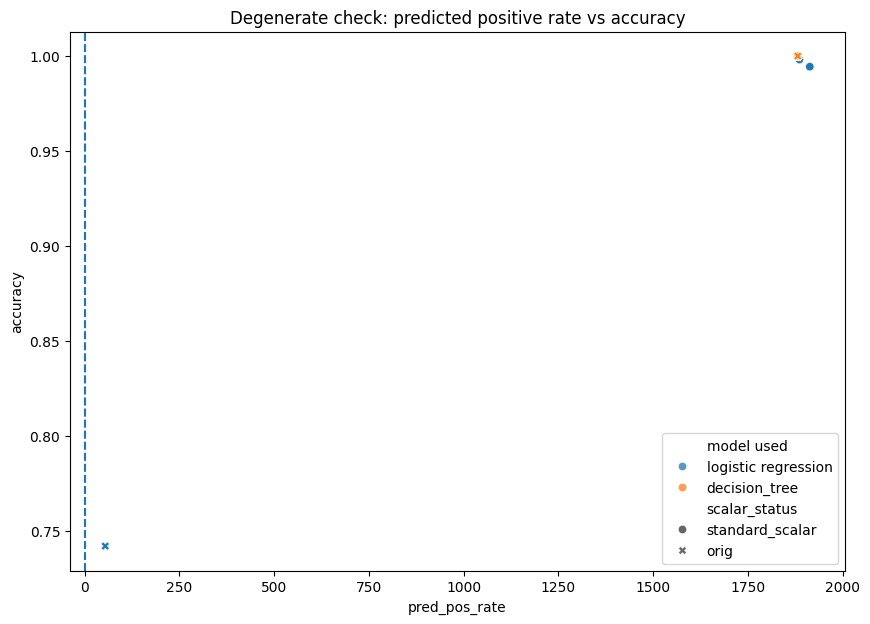

In [43]:
tmp = results_df.dropna(subset=["pred_pos_rate", primary_metric]).copy()

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=tmp,
    x="pred_pos_rate",
    y=primary_metric,
    hue="model used",
    style="scalar_status" if "scalar_status" in tmp.columns else None,
    alpha=0.75,
)
plt.axvline(0.0, linestyle="--")
plt.axvline(1.0, linestyle="--")
plt.title(f"Degenerate check: predicted positive rate vs {primary_metric}")

## Running hyperparam graphs

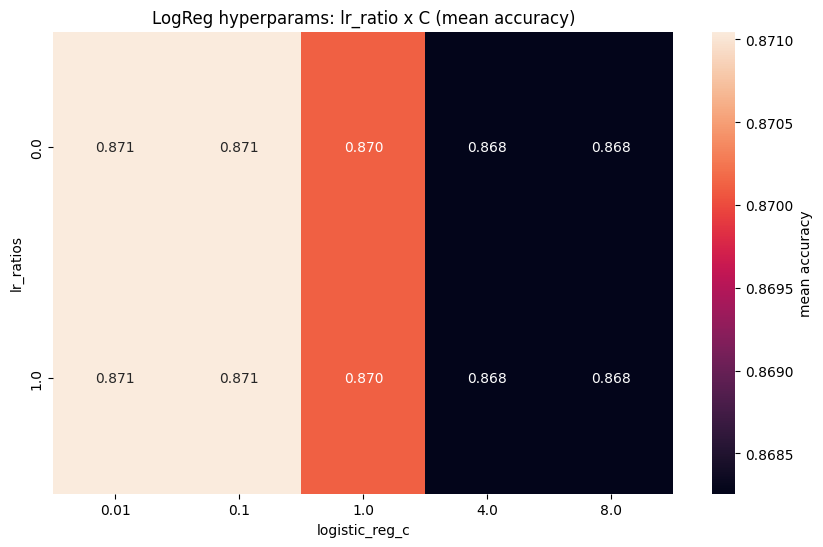

In [46]:
# logistic regression hyperparam heatmap
lr = results_df[results_df["model used"].str.contains("logistic", na=False)].copy()
if not lr.empty and "logistic_reg_c" in lr.columns and "lr_ratios" in lr.columns:
  lr["logistic_reg_c"] = pd.to_numeric(lr["logistic_reg_c"], errors="coerce")
  lr["lr_ratios"] = pd.to_numeric(lr["lr_ratios"], errors="coerce")
  lr = lr.dropna(subset=["logistic_reg_c", "lr_ratios", primary_metric])

  pivot = lr.pivot_table(
      index="lr_ratios",
      columns="logistic_reg_c",
      values=primary_metric,
      aggfunc="mean",
  )

  plt.figure(figsize=(10, 6))
  sns.heatmap(pivot, annot=True, fmt=".3f", cbar_kws={"label": f"mean {primary_metric}"})
  plt.title(f"LogReg hyperparams: lr_ratio x C (mean {primary_metric})")
else:
  print("no results for logistic regression")

In [47]:
# add graphs to show changes in primary metric based on
knn = results_df[results_df["model used"].str.contains("knn", na=False)].copy()
if not knn.empty and "knn_n_neighbor" in knn.columns and "knn_weights" in knn.columns:
    knn["knn_n_neighbor"] = pd.to_numeric(knn["knn_n_neighbor"], errors="coerce")
    knn = knn.dropna(subset=["knn_n_neighbor", "knn_weights", primary_metric])

    pivot = knn.pivot_table(
        index="knn_weights",
        columns="knn_n_neighbor",
        values=primary_metric,
        aggfunc="mean",
    )

    plt.figure(figsize=(10, 5))
    sns.heatmap(pivot, annot=True, fmt=".3f", cbar_kws={"label": f"mean {primary_metric}"})
    plt.title(f"KNN hyperparams: weights x n_neighbors (mean {primary_metric})")
else:
    print("no results for knn")

no results for knn


In [ ]:

# Assuming y_test (true labels) and y_scores (predicted probabilities) are available
# 1. Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# 2. Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Alternative: Using Scikit-Learn Display API
# PrecisionRecallDisplay.from_predictions(y_test, y_scores)
# plt.show()
